In [4]:
    """
    Make images similar to that done for the Great08 challenge:
      - Each fits file is 10 x 10 postage stamps.
        (The real Great08 images are 100x100, but in the interest of making the Demo
         script a bit quicker, we only build 100 stars and 100 galaxies.)
      - Each postage stamp is 40 x 40 pixels.
      - One image is all stars.
      - A second image is all galaxies.
      - Applied shear is the same for each galaxy.
      - Galaxies are oriented randomly, but in pairs to cancel shape noise.
      - Noise is Poisson using a nominal sky value of 1.e6.
      - Galaxies are Exponential profiles.
    """

# Copyright (c) 2012-2021 by the GalSim developers team on GitHub
# https://github.com/GalSim-developers
#
# This file is part of GalSim: The modular galaxy image simulation toolkit.
# https://github.com/GalSim-developers/GalSim
#
# GalSim is free software: redistribution and use in source and binary forms,
# with or without modification, are permitted provided that the following
# conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions, and the disclaimer given in the accompanying LICENSE
#    file.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions, and the disclaimer given in the documentation
#    and/or other materials provided with the distribution.
#
"""
Demo #5

The fifth script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)

This script is intended to mimic a Great08 (Bridle, et al, 2010) LowNoise image.
We produce a single image made up of tiles of postage stamps for each individual object.
(We only do 10 x 10 postage stamps rather than 100 x 100 as they did in the interest of time.)
Each postage stamp is 40 x 40 pixels.  One image is all stars.  A second image is all galaxies.
The stars are truncated Moffat profiles.  The galaxies are Exponential profiles.
(Great08 mixed pure bulge and pure disk for its LowNoise run.  We're just doing disks to
make things simpler. However see demo3 for an example of using bulge+disk galaxies.)
The galaxies are oriented randomly, but in 90 degree-rotated pairs to cancel the effect of
shape noise.  The applied shear is the same for each galaxy.

New features introduced in this demo:

- ud = galsim.UniformDeviate(seed)
- gd = galsim.GaussianDeviate(ud, sigma)
- ccdnoise = galsim.CCDNoise(ud)
- image *= scalar
- bounds = galsim.BoundsI(xmin, xmax, ymin, ymax)
- pos = bounds.center
- pos.x, pos.y
- sub_image = image[bounds]

- Build a single large image, and access sub-images within it.
- Set the galaxy size based on the PSF size and a resolution factor.
- Set the object's flux according to a target S/N value.
- Use 90 degree-rotated pairs for the intrinsic galaxy shapes.
- Shift by a random (dx, dy) drawn from a unit circle top hat.
"""

import sys
import os
import math
import numpy
import logging
import time
import galsim

def main(argv):

    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("demo5")

    # Define some parameters we'll use below.
    # Normally these would be read in from some parameter file.

    nx_tiles = 10                   #
    ny_tiles = 10                   #
    stamp_xsize = 40                #
    stamp_ysize = 40                #

    random_seed = 6424512           #

    pixel_scale = 1.0               # arcsec / pixel
    sky_level = 1.e6                # ADU / arcsec^2

    # Make output directory if not already present.
    if not os.path.isdir('output'):
        os.mkdir('output')
    psf_file_name = os.path.join('output','g08_psf.fits')
    psf_beta = 3                    #
    psf_fwhm = 2.85                 # arcsec (=pixels)
    psf_trunc = 2.*psf_fwhm         # arcsec (=pixels)
    psf_e1 = -0.019                 #
    psf_e2 = -0.007                 #

    gal_file_name = os.path.join('output','g08_gal.fits')
    gal_signal_to_noise = 200       # Great08 "LowNoise" run
    gal_resolution = 0.98           # r_gal / r_psf (use r = half_light_radius)
    # Note: Great08 defined their resolution as r_obs / r_psf, using the convolved
    #       size rather than the pre-convolved size.
    #       Therefore, our r_gal/r_psf = 0.98 approximately corresponds to
    #       their r_obs / r_psf = 1.4.

    gal_ellip_rms = 0.2             # using "distortion" definition of ellipticity:
                                    #   e = (a^2-b^2)/(a^2+b^2), where a and b are the
                                    #   semi-major and semi-minor axes, respectively.
    gal_ellip_max = 0.6             # Maximum value of e, to avoid getting near e=1.
    gal_g1 = 0.013                  # Applied shear, using normal shear definition:
    gal_g2 = -0.008                 #   g = (a-b)/(a+b)

    shift_radius = 1.0              # arcsec (=pixels)

    logger.info('Starting demo script 5 using:')
    logger.info('    - image with %d x %d postage stamps',nx_tiles,ny_tiles)
    logger.info('    - postage stamps of size %d x %d pixels',stamp_xsize,stamp_ysize)
    logger.info('    - Moffat PSF (beta = %.1f, FWHM = %.2f, trunc = %.2f),',
                psf_beta,psf_fwhm,psf_trunc)
    logger.info('    - PSF ellip = (%.3f,%.3f)',psf_e1,psf_e2)
    logger.info('    - Exponential galaxies')
    logger.info('    - Resolution (r_gal / r_psf) = %.2f',gal_resolution)
    logger.info('    - Ellipticities have rms = %.1f, max = %.1f',
                gal_ellip_rms, gal_ellip_max)
    logger.info('    - Applied gravitational shear = (%.3f,%.3f)',gal_g1,gal_g2)
    logger.info('    - Poisson noise (sky level = %.1e).', sky_level)
    logger.info('    - Centroid shifts up to = %.2f pixels',shift_radius)


    # Define the PSF profile
    psf = galsim.Moffat(beta=psf_beta, fwhm=psf_fwhm, trunc=psf_trunc)

    # When something can be constructed from multiple sizes, e.g. Moffat, then
    # you can get any size out even if it wasn't the way the object was constructed.
    # In this case, we extract the half-light radius, even though we built it with fwhm.
    # We'll use this later to set the galaxy's half-light radius in terms of a resolution.
    psf_re = psf.half_light_radius

    psf = psf.shear(e1=psf_e1,e2=psf_e2)
    logger.debug('Made PSF profile')

    # Define the galaxy profile

    # First figure out the size we need from the resolution
    gal_re = psf_re * gal_resolution

    # Make the galaxy profile starting with flux = 1.
    gal = galsim.Exponential(flux=1., half_light_radius=gal_re)
    logger.debug('Made galaxy profile')

    # This profile is placed with different orientations and noise realizations
    # at each postage stamp in the gal image.
    gal_image = galsim.ImageF(stamp_xsize * nx_tiles-1 , stamp_ysize * ny_tiles-1,
                              scale=pixel_scale)
    psf_image = galsim.ImageF(stamp_xsize * nx_tiles-1 , stamp_ysize * ny_tiles-1,
                              scale=pixel_scale)

    shift_radius_sq = shift_radius**2

    first_in_pair = True  # Make pairs that are rotated by 90 degrees

    k = 0
    for iy in range(ny_tiles):
        for ix in range(nx_tiles):
            # The normal procedure for setting random numbers in GalSim is to start a new
            # random number generator for each object using sequential seed values.
            # This sounds weird at first (especially if you were indoctrinated by Numerical
            # Recipes), but for the boost random number generator we use, the "random"
            # number sequences produced from sequential initial seeds are highly uncorrelated.
            #
            # The reason for this procedure is that when we use multiple processes to build
            # our images, we want to make sure that the results are deterministic regardless
            # of the way the objects get parcelled out to the different processes.
            #
            # Of course, this script isn't using multiple processes, so it isn't required here.
            # However, we do it nonetheless in order to get the same results as the config
            # version of this demo script (demo5.yaml).
            ud = galsim.UniformDeviate(random_seed+k+1)

            # Any kind of random number generator can take another RNG as its first
            # argument rather than a seed value.  This makes both objects use the same
            # underlying generator for their pseudo-random values.
            gd = galsim.GaussianDeviate(ud, sigma=gal_ellip_rms)

            # The -1's in the next line are to provide a border of
            # 1 pixel between postage stamps
            b = galsim.BoundsI(ix*stamp_xsize+1 , (ix+1)*stamp_xsize-1,
                               iy*stamp_ysize+1 , (iy+1)*stamp_ysize-1)
            sub_gal_image = gal_image[b]
            sub_psf_image = psf_image[b]

            # Great08 randomized the locations of the two galaxies in each pair,
            # but for simplicity, we just do them in sequential postage stamps.
            if first_in_pair:
                # Use a random orientation:
                beta = ud() * 2. * math.pi * galsim.radians

                # Determine the ellipticity to use for this galaxy.
                ellip = 1
                while (ellip > gal_ellip_max):
                    # Don't do `ellip = math.fabs(gd())`
                    # Python basically implements this as a macro, so gd() is called twice!
                    val = gd()
                    ellip = math.fabs(val)

                # Make a new copy of the galaxy with an applied e1/e2-type distortion
                # by specifying the ellipticity and a real-space position angle
                ellip_gal = gal.shear(e=ellip, beta=beta)

                first_in_pair = False
            else:
                # Use the previous ellip_gal profile and rotate it by 90 degrees
                ellip_gal = ellip_gal.rotate(90 * galsim.degrees)

                first_in_pair = True

            # Apply the gravitational reduced shear by specifying g1/g2
            this_gal = ellip_gal.shear(g1=gal_g1, g2=gal_g2)

            # Apply a random shift_radius:
            rsq = 2 * shift_radius_sq
            while (rsq > shift_radius_sq):
                dx = (2*ud()-1) * shift_radius
                dy = (2*ud()-1) * shift_radius
                rsq = dx**2 + dy**2

            this_gal = this_gal.shift(dx,dy)
            # Note that the shifted psf that we create here is purely for the purpose of being able
            # to draw a separate, shifted psf image.  We do not use it when convolving the galaxy
            # with the psf.
            this_psf = psf.shift(dx,dy)

            # Make the final image, convolving with the (unshifted) psf
            final_gal = galsim.Convolve([psf,this_gal])

            # Draw the image
            final_gal.drawImage(sub_gal_image)

            # Now add an appropriate amount of noise to get our desired S/N
            # There are lots of definitions of S/N, but here is the one used by Great08
            # We use a weighted integral of the flux:
            #   S = sum W(x,y) I(x,y) / sum W(x,y)
            #   N^2 = Var(S) = sum W(x,y)^2 Var(I(x,y)) / (sum W(x,y))^2
            # Now we assume that Var(I(x,y)) is constant so
            #   Var(I(x,y)) = noise_var
            # We also assume that we are using a matched filter for W, so W(x,y) = I(x,y).
            # Then a few things cancel and we find that
            # S/N = sqrt( sum I(x,y)^2 / noise_var )
            #
            # The above procedure is encapsulated in the function image.addNoiseSNR which
            # sets the flux appropriately given the variance of the noise model.
            # In our case, noise_var = sky_level_pixel
            sky_level_pixel = sky_level * pixel_scale**2
            noise = galsim.PoissonNoise(ud, sky_level=sky_level_pixel)
            sub_gal_image.addNoiseSNR(noise, gal_signal_to_noise)

            # Draw the PSF image
            # No noise on PSF images.  Just draw it as is.
            this_psf.drawImage(sub_psf_image)

            # For first instance, measure moments
            if ix==0 and iy==0:
                psf_shape = sub_psf_image.FindAdaptiveMom()
                temp_e = psf_shape.observed_shape.e
                if temp_e > 0.0:
                    g_to_e = psf_shape.observed_shape.g / temp_e
                else:
                    g_to_e = 0.0
                logger.info('Measured best-fit elliptical Gaussian for first PSF image: ')
                logger.info('  g1, g2, sigma = %7.4f, %7.4f, %7.4f (pixels)',
                            g_to_e*psf_shape.observed_shape.e1,
                            g_to_e*psf_shape.observed_shape.e2, psf_shape.moments_sigma)

            x = b.center.x
            y = b.center.y
            logger.info('Galaxy (%d,%d): center = (%.0f,%0.f)  (e,beta) = (%.4f,%.3f)',
                        ix,iy,x,y,ellip,beta/galsim.radians)
            k = k+1

    logger.info('Done making images of postage stamps')

    # Now write the images to disk.
    psf_image.write(psf_file_name)
    logger.info('Wrote PSF file %s',psf_file_name)

    gal_image.write(gal_file_name)
    logger.info('Wrote image to %r',gal_file_name)  # using %r adds quotes around filename for us


if __name__ == "__main__":
    main(sys.argv)

Starting demo script 5 using:
    - image with 10 x 10 postage stamps
    - postage stamps of size 40 x 40 pixels
    - Moffat PSF (beta = 3.0, FWHM = 2.85, trunc = 5.70),
    - PSF ellip = (-0.019,-0.007)
    - Exponential galaxies
    - Resolution (r_gal / r_psf) = 0.98
    - Ellipticities have rms = 0.2, max = 0.6
    - Applied gravitational shear = (0.013,-0.008)
    - Poisson noise (sky level = 1.0e+06).
    - Centroid shifts up to = 1.00 pixels
Measured best-fit elliptical Gaussian for first PSF image: 
  g1, g2, sigma = -0.0090, -0.0033,  1.4107 (pixels)
Galaxy (0,0): center = (20,20)  (e,beta) = (0.2696,4.878)
Galaxy (1,0): center = (60,20)  (e,beta) = (0.2696,4.878)
Galaxy (2,0): center = (100,20)  (e,beta) = (0.0147,2.053)
Galaxy (3,0): center = (140,20)  (e,beta) = (0.0147,2.053)
Galaxy (4,0): center = (180,20)  (e,beta) = (0.1135,1.523)
Galaxy (5,0): center = (220,20)  (e,beta) = (0.1135,1.523)
Galaxy (6,0): center = (260,20)  (e,beta) = (0.1132,4.737)
Galaxy (7,0): center 

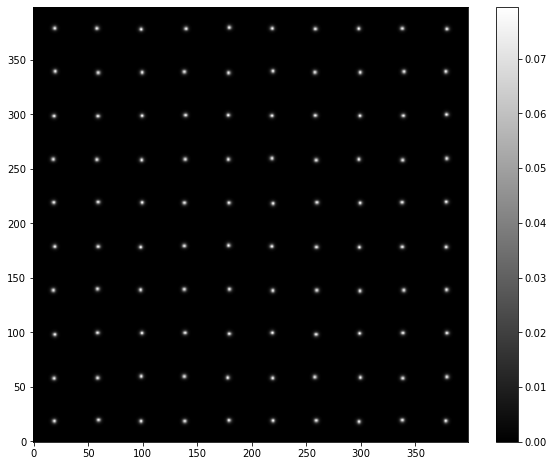

In [6]:
from astropy.utils.data import download_file
from astropy.io import fits
image_file = "output//g08_psf.fits"
import matplotlib.pyplot as plt
#get data quickly
image_data = fits.getdata(image_file)
#numpy swap rows and cols
plt.figure(figsize=(10,8))
plt.imshow(image_data.T, cmap='gray', origin='lower')
plt.colorbar();

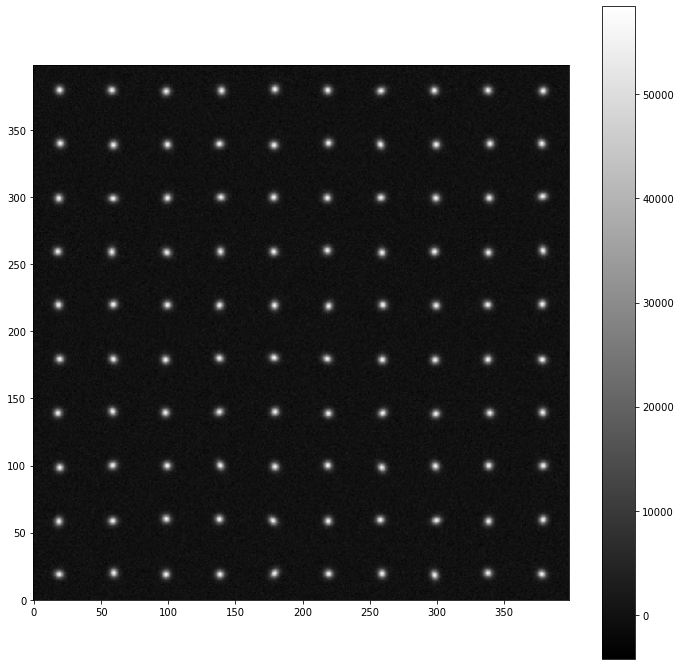

In [5]:
image_file = "output//g08_gal.fits"
import matplotlib.pyplot as plt
#get data quickly
image_data = fits.getdata(image_file)
#numpy swap rows and cols
plt.figure(figsize=(12,12))
plt.imshow(image_data.T, cmap='gray', origin='lower')
plt.colorbar();